In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
goal_space_dict = dict()
true_goal_dict = dict()

#Category 0- control
goal_space_dict["0_1"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["0_1"] = "core" 
goal_space_dict["0_2"] = ["wad", "reap", "war", "wade", "draw"]
true_goal_dict["0_2"] = "wade"
goal_space_dict["0_3"] = ["wad", "reap", "war", "wade", "draw"]
true_goal_dict["0_3"] = "war"
goal_space_dict["0_4"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["0_4"] = "cower"

#Category 1- 
goal_space_dict["1_1"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["1_1"] = "power"
goal_space_dict["1_2"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["1_2"] = "cower"
goal_space_dict["1_3"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["1_3"] = "core"
goal_space_dict["1_4"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["1_4"] = "crow"

#Category 2- misspelled word
goal_space_dict["2_1"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["2_1"] = "cower"
goal_space_dict["2_2"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["2_2"] = "pore"
goal_space_dict["2_3"] = ["ear", "reap", "pear", "wade", "draw"]
true_goal_dict["2_3"] = "reap"
goal_space_dict["2_4"] = ["wad", "reap", "war", "wade", "draw"]
true_goal_dict["2_4"] = "draw"

#Category 3- moving irrelevant blocks
goal_space_dict["3_1"] = ["cower", "war", "wear", "crow", "core"]
true_goal_dict["3_1"] = "war"
goal_space_dict["3_2"] = ["cower", "war", "wear", "crow", "core"]
true_goal_dict["3_2"] = "cower"
goal_space_dict["3_3"] = ["cower", "war", "wear", "crow", "core"]
true_goal_dict["3_3"] = "core"
goal_space_dict["3_4"] = ["cower", "war", "wear", "crow", "core"]
true_goal_dict["3_4"] = "crow"

#experiment 4a - initial configuration matches goal state
goal_space_dict["4_1"] = ["power", "cower", "crow", "core", "pore"]
true_goal_dict["4_1"] = "core"
goal_space_dict["4_2"] = ["raw", "paw", "draw", "war", "wear"]
true_goal_dict["4_2"] = "draw"
goal_space_dict["4_3"] = ["ear", "paw", "dear", "war", "wear"]
true_goal_dict["4_3"] = "wear"
goal_space_dict["4_4"] = ["raw", "paw", "draw", "war", "wear"]
true_goal_dict["4_4"] = "wear"


In [3]:
font = {'size'   : 16}

matplotlib.rc('font', **font)

goal_colors = ['#0c0787', '#7e02a8',  
          '#cb4778', '#f89441', '#f0f921'] 

 # Load data and clean data

In [4]:
with open('database-export.json') as file:
    data = json.load(file)
results = data['results']

assignemnts_data = pd.read_csv("demographics/Batch_4270661_batch_results.csv", header=0)
assignemnts_data_2 = pd.read_csv("demographics/Batch_4270670_batch_results.csv", header=0)
id_list = np.append(assignemnts_data['Answer.experimentcode'].values, assignemnts_data_2['Answer.experimentcode'].values)
id_list = list(map(str, id_list))
workers_dict = dict.fromkeys(id_list, 0)
exp_dict = dict()


# rejected =[1607115047337,
# 1607115070015,
# 1607115116358,
# 1607115480159,
# 1607115552593,
# 1607116558958,
# 1607117474340,
# 1607117492816,
# 1607125963924,
# 1607116912260,
# 1607115323722,
# 1607120548427,
# 1607126650608,
# 1607117907163,
# 1607118854103,
# 1607115018235,
# 1607117830583,
# 1607117440250,
# 1607115873532,
# 1607121165107,
# 1607117172687,
# 1607116510666
# ]

rejected =[]


In [5]:
workers_dict = dict.fromkeys(id_list, 0)
exp_dict = dict()
for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if current_id not in workers_dict.keys(): 
        continue 
    if workers_dict[current_id] == 0: 
        workers_dict[current_id] = {'reward_score': 0, 'min_time': 1000000, 'default': False}
    if len(key) == 2: #the entry is tutorial
        workers_dict[current_id]['tutorial_final_prob'] = entry[-1]['true_goal_probs']  
    else: #the entry is an experiment
        exp = "_".join(key[-2:])
        if exp in exp_dict.keys(): 
            exp_dict[exp].append(current_id)
        else: 
            exp_dict[exp] = [current_id]
        workers_dict[current_id]['reward_score'] += entry[-1]['reward_score']/entry[-1]['timestep']
        time = []
        for step in entry: 
            time.append(step['time_spent'])
        if min(time) < workers_dict[current_id]['min_time'] and min(time) != 0: 
            workers_dict[current_id]['min_time'] = min(time)
        if [entry[-1]['goal_probs_0'], entry[-1]['goal_probs_1'], 
            entry[-1]['goal_probs_2'], entry[-1]['goal_probs_3'], 
            entry[-1]['goal_probs_4']] == [0.2,0.2,0.2,0.2,0.2]: 
            workers_dict[current_id]['default'] = True
            
#flaggining workers 
flagged_ids = []
for key, worker in workers_dict.items(): 
    if worker['min_time'] < 2.0 or worker['tutorial_final_prob'] < 0.7 or worker['default']: 
        worker['flag'] = True
        flagged_ids.append(key)
    else: 
        worker['flag'] = False
        
#counting experiments
exp_counter = {}
for key, exp in exp_dict.items(): 
    exp_counter[key] = {}
    exp_counter[key]['total'] = len(exp)
    intersection = list(set(exp) & set(flagged_ids)) 
    exp_counter[key]['possibly_rejected'] = len(intersection)
    
    

In [6]:
## ids_dict: primary key is user id secondary key is exeriment [tutorial, 0-1,0-2,....] 
## third level key is goal ['goal_probs_0'] and time_spent, timestep, and reward_score

ids_dict = dict.fromkeys(id_list, 0)
for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if current_id not in ids_dict.keys(): 
        continue
    if ids_dict[current_id] == 0: 
        ids_dict[current_id] = {}
    if len(key) == 2: #the entry is tutorial
        ids_dict[current_id]['tutorial'] = entry
    else:
        exp = "_".join(key[-2:])
        time_steps = [d['timestep'] for d in entry]
        if len(time_steps) == max(time_steps):
            ids_dict[current_id][exp] = entry
        else: 
            ids_dict[current_id][exp] = entry[7:]

In [7]:
# primary key is problem number, secondary key is timestep, values are list of dictionaries with keys column_order and additional user_id column
predictions_dict = dict()
column_order = ['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4','true_goal_probs','time_spent','reward_score']

for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if current_id not in workers_dict.keys(): 
        continue 
    if workers_dict[current_id] == 0: 
        workers_dict[current_id] = {'reward_score': 0, 'min_time': 1000000, 'default': False}
    if len(key) == 2: #the entry is tutorial
        workers_dict[current_id]['tutorial_final_prob'] = entry[-1]['true_goal_probs']  
    else: #the entry is an experiment
        exp = "_".join(key[-2:])
        # build prediction if user not rejected

        if int(current_id) in rejected:
            print(current_id)
            continue
        predictions_dict[exp] = predictions_dict.get(exp, dict())
        for timestep in entry:
            time = timestep['timestep']
            step = {}
            # skip tutorial or bad timestep
            if timestep['time_spent'] == 0:
                continue
            for column in column_order:
                step[column] = round(timestep[column],2)
            step['user_id'] = current_id
            predictions_dict[exp][time] = predictions_dict[exp].get(time, [])
            predictions_dict[exp][time].append(step)

In [8]:
predictions_dict["2_1"]

{1: [{'goal_probs_0': 0.2,
   'goal_probs_1': 0.2,
   'goal_probs_2': 0.2,
   'goal_probs_3': 0.2,
   'goal_probs_4': 0.2,
   'true_goal_probs': 0.2,
   'time_spent': 7.46,
   'reward_score': 0.2,
   'user_id': '1607114805281'},
  {'goal_probs_0': 0.2,
   'goal_probs_1': 0.2,
   'goal_probs_2': 0.2,
   'goal_probs_3': 0.2,
   'goal_probs_4': 0.2,
   'true_goal_probs': 0.2,
   'time_spent': 9.39,
   'reward_score': 0.2,
   'user_id': '1607115041322'},
  {'goal_probs_0': 0.2,
   'goal_probs_1': 0.2,
   'goal_probs_2': 0.2,
   'goal_probs_3': 0.2,
   'goal_probs_4': 0.2,
   'true_goal_probs': 0.2,
   'time_spent': 4.18,
   'reward_score': 0.2,
   'user_id': '1607115408614'},
  {'goal_probs_0': 0.2,
   'goal_probs_1': 0.2,
   'goal_probs_2': 0.2,
   'goal_probs_3': 0.2,
   'goal_probs_4': 0.2,
   'true_goal_probs': 0.2,
   'time_spent': 5.41,
   'reward_score': 0.2,
   'user_id': '1607115756133'},
  {'goal_probs_0': 0.17,
   'goal_probs_1': 0.17,
   'goal_probs_2': 0.31,
   'goal_probs_3':

## Finding outliers

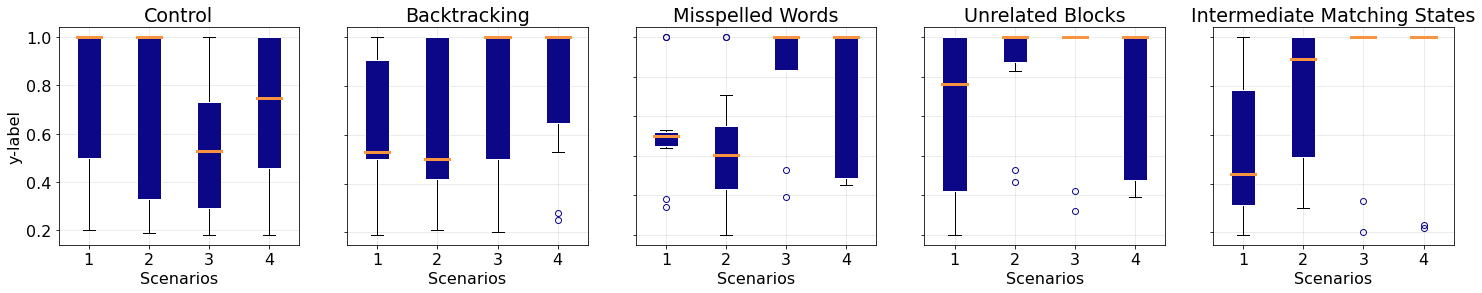

In [9]:
outliers = dict()
cutoff = 1 
i = 0
fig, axs = plt.subplots(1, 5, figsize=[25,4])
categories = ['Control', 'Backtracking', 'Misspelled Words', 'Unrelated Blocks', 'Intermediate Matching States']
for category in range(5):
    true_goals = []
    labels = []
    for scenario in range(1,5):
        exp = "{0}_{1}".format(category,scenario)
        labels.append(scenario)
        final_time = max(predictions_dict[exp].keys())
        df = pd.DataFrame.from_dict(predictions_dict[exp][final_time], orient='columns', dtype=None, columns=None)
        true_goal_probs = df['true_goal_probs'].values
        true_goals.append(true_goal_probs)
        median = np.median(true_goal_probs)
        q25, q75 = np.percentile(true_goal_probs, 25), np.percentile(true_goal_probs, 75)
        iqr = q75 - q25
        lower_limit = q25 - cutoff * iqr
        outliers_values = [x for x in true_goal_probs if x < lower_limit]
        df = df[df['true_goal_probs'] < lower_limit]
        ids_ = df['user_id'].values
#         if len(ids_): 
        outliers[exp] = ids_
    axs[category].boxplot(true_goals, widths=0.4, 
                patch_artist=True, labels = labels,
                whis = cutoff,
                boxprops=dict(facecolor=goal_colors[0], color='w'),
                medianprops = dict(linewidth=3, color=goal_colors[3]), 
                flierprops=dict(color=goal_colors[3], markeredgecolor=goal_colors[0]))
    axs[category].set_title(categories[category])
    axs[category].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
#     axs[category].setp(item, dict(facecolor=goal_colors[0], color=goal_colors[1]))

for ax in axs.flat:
    ax.set(xlabel='Scenarios', ylabel='y-label')
for ax in axs.flat:
    ax.label_outer()

fig.savefig('plots/human_data_var.png', dpi=400, bbox_inches="tight")

In [10]:
outliers

{'0_1': array([], dtype=object),
 '0_2': array([], dtype=object),
 '0_3': array([], dtype=object),
 '0_4': array([], dtype=object),
 '1_1': array([], dtype=object),
 '1_2': array([], dtype=object),
 '1_3': array([], dtype=object),
 '1_4': array(['1607117492816', '1607126650608'], dtype=object),
 '2_1': array(['1607121165107', '1607125963924'], dtype=object),
 '2_2': array([], dtype=object),
 '2_3': array(['1607115552593', '1607120548427'], dtype=object),
 '2_4': array([], dtype=object),
 '3_1': array([], dtype=object),
 '3_2': array(['1607117492816', '1607126650608'], dtype=object),
 '3_3': array(['1607117440250', '1607118854103'], dtype=object),
 '3_4': array([], dtype=object),
 '4_1': array([], dtype=object),
 '4_2': array([], dtype=object),
 '4_3': array(['1607115018235', '1607115873532'], dtype=object),
 '4_4': array(['1607117440250', '1607118854103'], dtype=object)}

In [11]:
# primary key is problem number, secondary key is timestep, values are list of dictionaries with keys column_order and additional user_id column
predictions_dict_cleaned = dict()
column_order = ['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4','true_goal_probs','time_spent','reward_score']

for key, entry in results.items():
    key = key.split("_")
    current_id = key[0]
    if len(key) == 2: #the entry is tutorial
        continue
    else: #the entry is an experiment
        exp = "_".join(key[-2:])
        # build prediction if user not rejected
        if current_id in outliers[exp]:
            print(current_id)
            continue
        predictions_dict_cleaned[exp] = predictions_dict_cleaned.get(exp, dict())
        for timestep in entry:
            time = timestep['timestep']
            step = {}
            # skip tutorial or bad timestep
            if timestep['time_spent'] == 0:
                continue
            for column in column_order:
                step[column] = round(timestep[column],2)
            step['user_id'] = current_id
            predictions_dict_cleaned[exp][time] = predictions_dict_cleaned[exp].get(time, [])
            predictions_dict_cleaned[exp][time].append(step)
            

1607115018235
1607115552593
1607115873532
1607117440250
1607117440250
1607117492816
1607117492816
1607118854103
1607118854103
1607120548427
1607121165107
1607125963924
1607126650608
1607126650608


## Plotting probability trajectories

In [12]:
import csv

def generate_sips_mean_array(filename):
    mean_array = np.array([0,0,0,0,0])
    with open("sips_results/" + filename) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='\'')
        for row in csvreader:
            if len(row) > 2:
                time = row[0]
                mean = []
                for i in range(1,6):
                    prob = row[i]
                    # parse string into float
                    prob = prob.replace("\"", "").replace("[", "").replace("]", "")
                    prob = float(prob)
                    mean.append(prob)
                mean_array = np.vstack([mean_array, np.array(mean)])
        return mean_array[1:]


In [13]:
def format_legend(exp): 
    legend = goal_space_dict[exp].copy() 
    true_goal = legend.index(true_goal_dict[exp])
    legend[true_goal] = legend[true_goal] + " (true goal)"
    return legend

In [14]:
def plot_probs(exp):
    c,p = exp.split("_")
    filename = "experiment-" + str(c) + "-" + str(p) + ".csv"
    sips_mean_array= generate_sips_mean_array(filename)

    fig, axs = plt.subplots(2, 1, figsize=[25,8])
    huma_data = predictions_dict_cleaned[exp]
    mean_array = np.array([0,0,0,0,0])
    std_array = np.array([0,0,0,0,0])
    for step, data in huma_data.items(): 
        goals_probs = pd.DataFrame.from_dict(data, orient='columns', dtype=None, columns=None)
        goals_probs = goals_probs[['goal_probs_0', 'goal_probs_1', 'goal_probs_2', 'goal_probs_3', 'goal_probs_4']].values
        mean = np.mean(goals_probs, axis=0)
        std = np.std(goals_probs, axis=0)
        mean_array = np.vstack([mean_array, mean])
        std_array = np.vstack([std_array, std])
    mean_array = mean_array[1:]
    std_array = std_array[1:]
    for i in range(mean_array.shape[1]): 
        axs[0].plot(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[0].scatter(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i], color=goal_colors[i])
        axs[0].fill_between(range(1, mean_array.shape[0]*2+1,2), mean_array[:,i] - std_array[:,i], mean_array[:,i] + std_array[:,i], color=goal_colors[i], alpha=0.2)
    title = exp.split("_")
    axs[0].set_title("{0} Scenario {1} - human results".format(categories[int(title[0])], title[1]))
    axs[0].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[0].set_ylim([-0.01,1.01])
    axs[0].set_xlim([1,sips_mean_array.shape[0]])
    axs[0].legend(format_legend(exp), loc = 'upper left', fancybox=True, framealpha=0, fontsize=14)
    for i in range(sips_mean_array.shape[1]): 
        axs[1].plot(range(1, sips_mean_array.shape[0]+1), sips_mean_array[:,i], color=goal_colors[i], linewidth=4)
        axs[1].scatter(range(1, sips_mean_array.shape[0]+1), sips_mean_array[:,i], color=goal_colors[i])
    title = exp.split("_")
    axs[1].set_title("{0} Scenario {1} - SIPS results".format(categories[int(title[0])], title[1]))
    axs[1].grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    axs[1].set_ylim([-0.01,1.01])
    axs[1].set_xlim([1,sips_mean_array.shape[0]])
    fig.savefig('plots/sips/prob_traj_{}.png'.format(exp), dpi=400)
    for ax in axs.flat:
        ax.label_outer()
#     print(sips_mean_array.shape)
#     print(mean_array)    

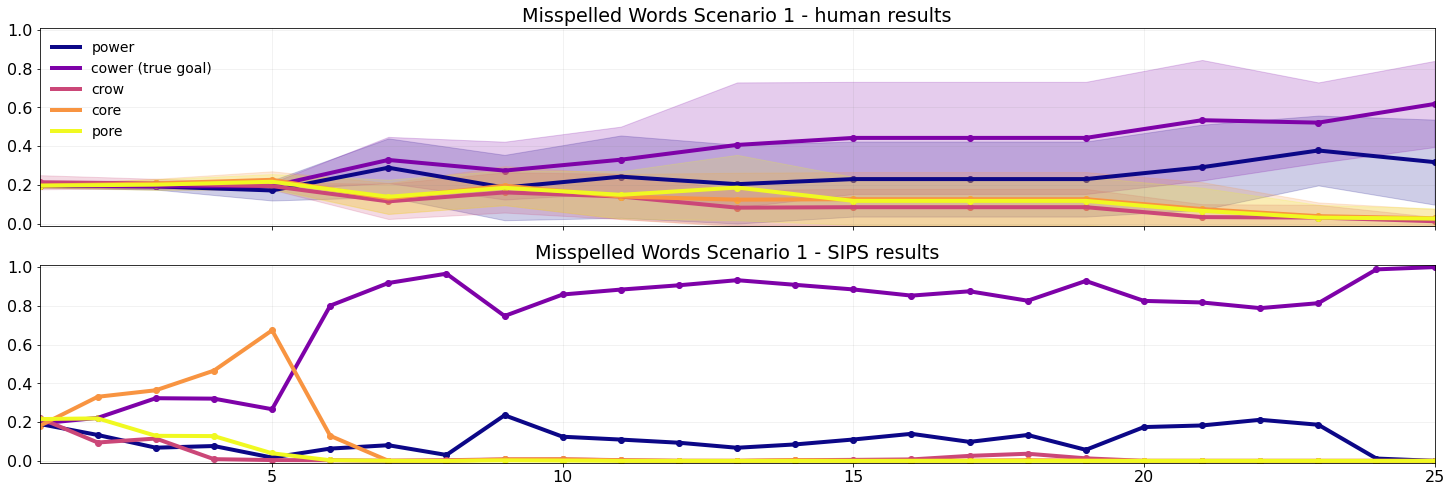

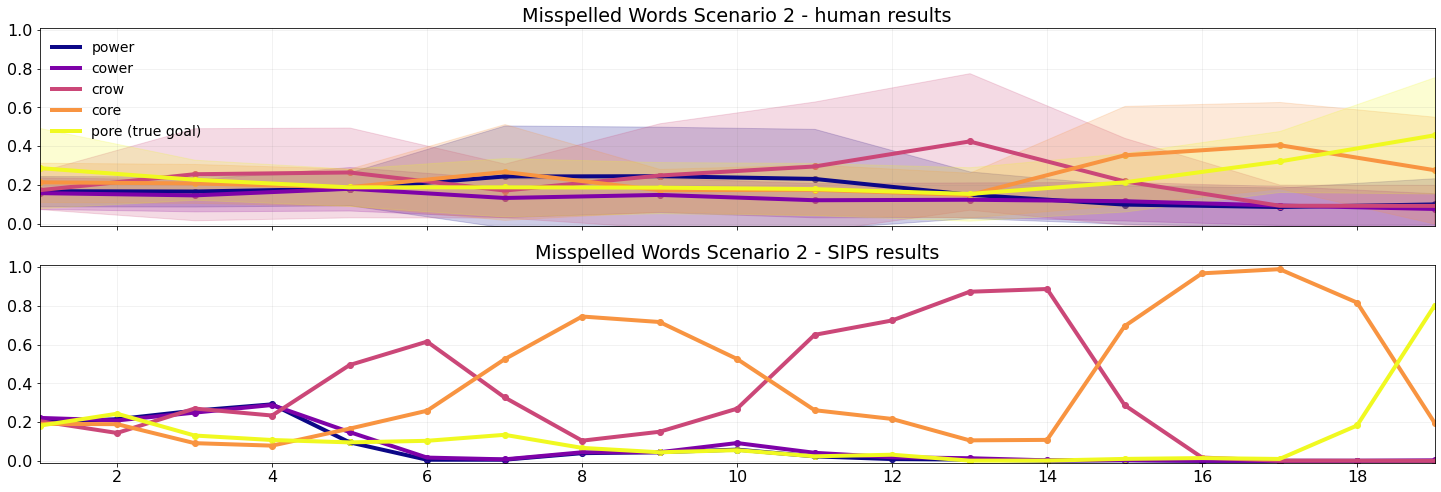

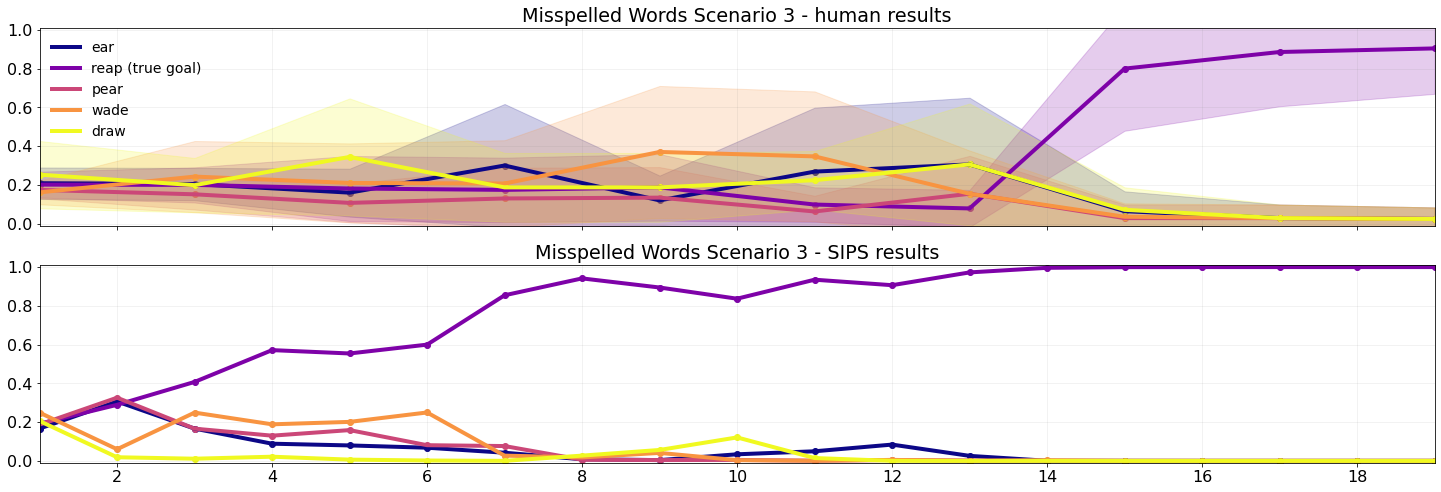

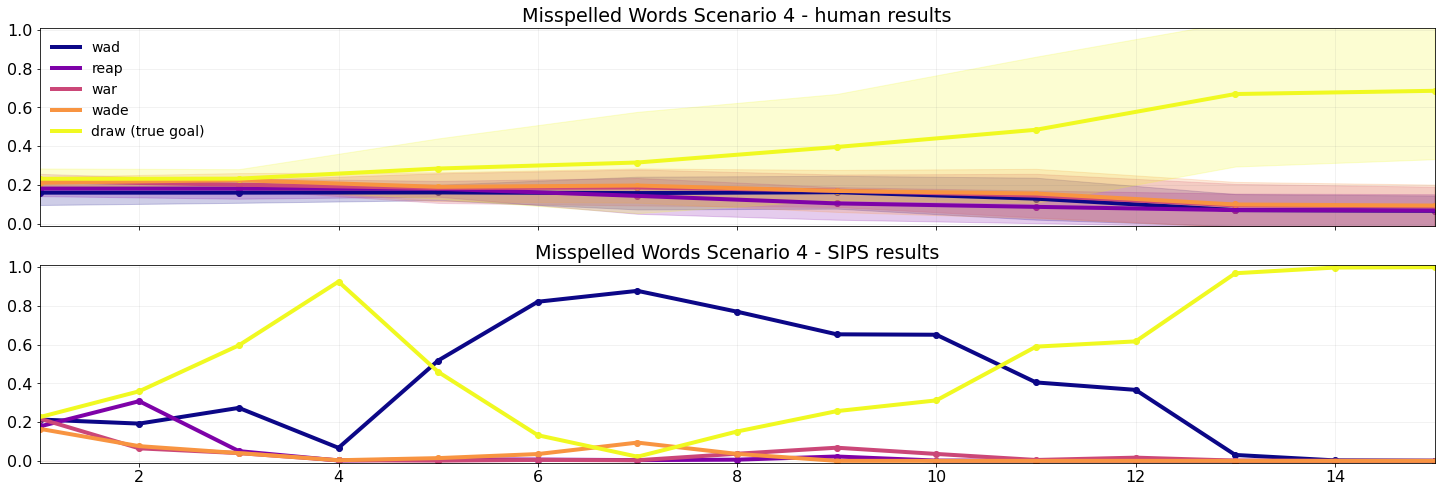

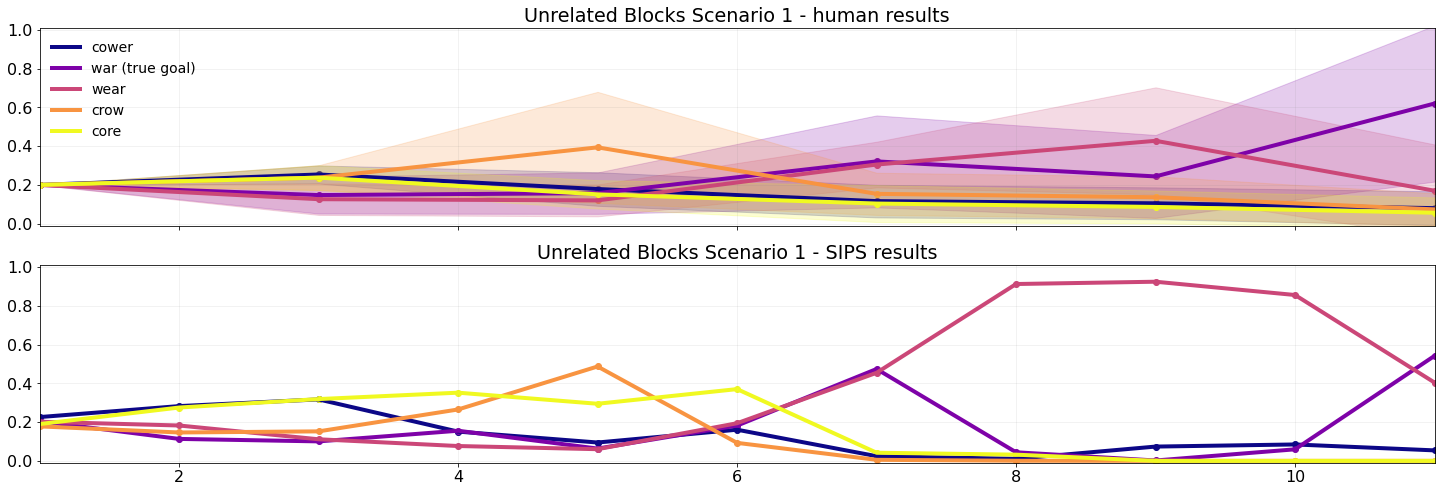

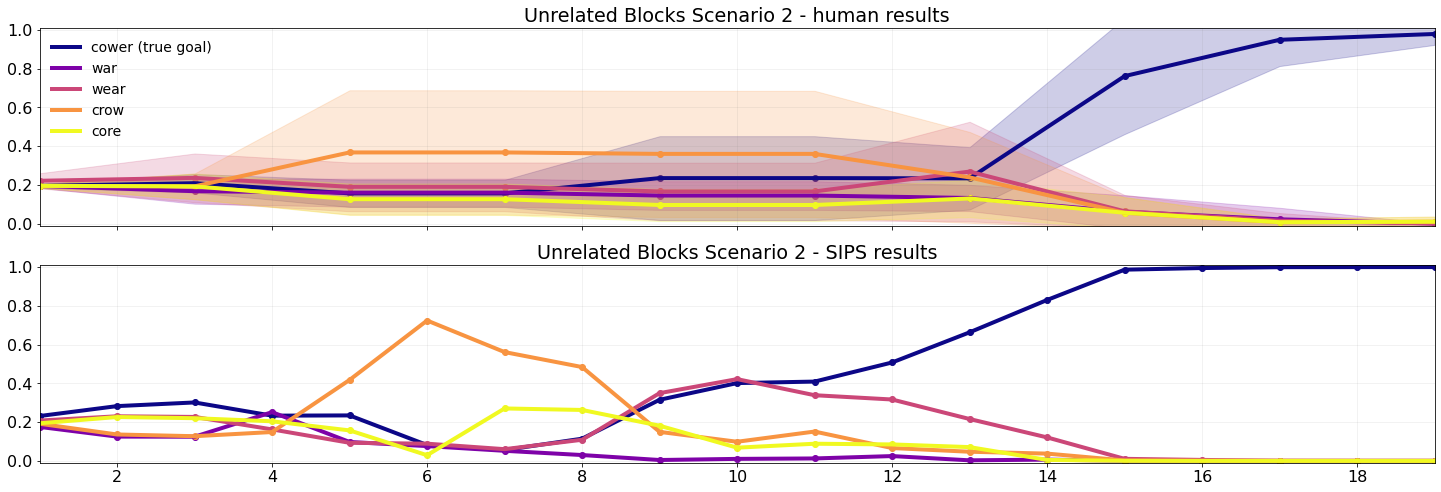

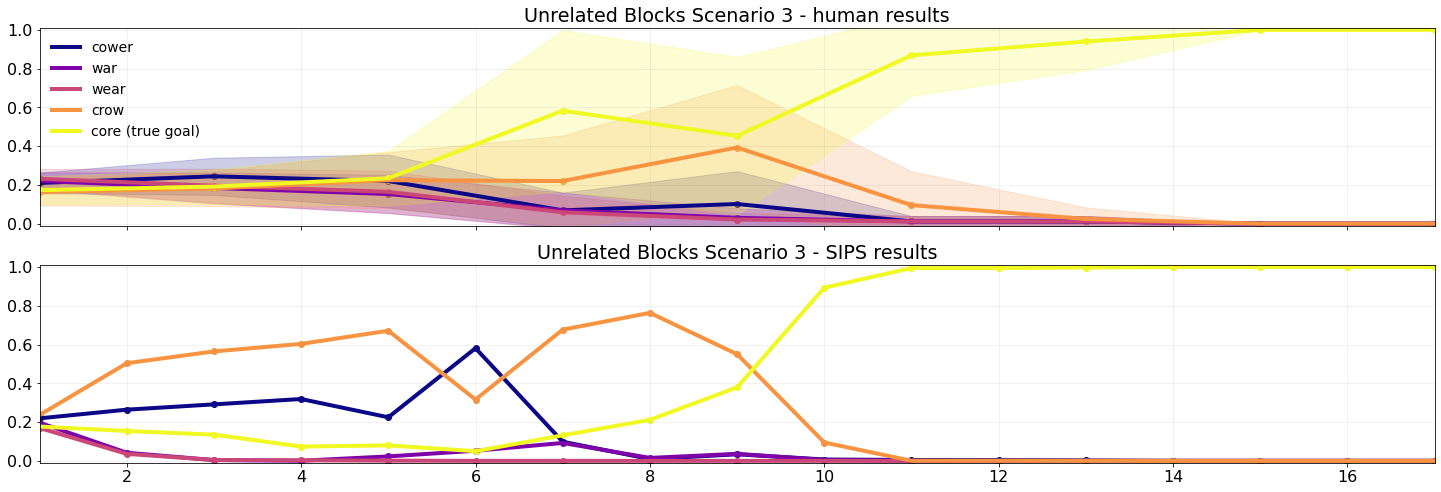

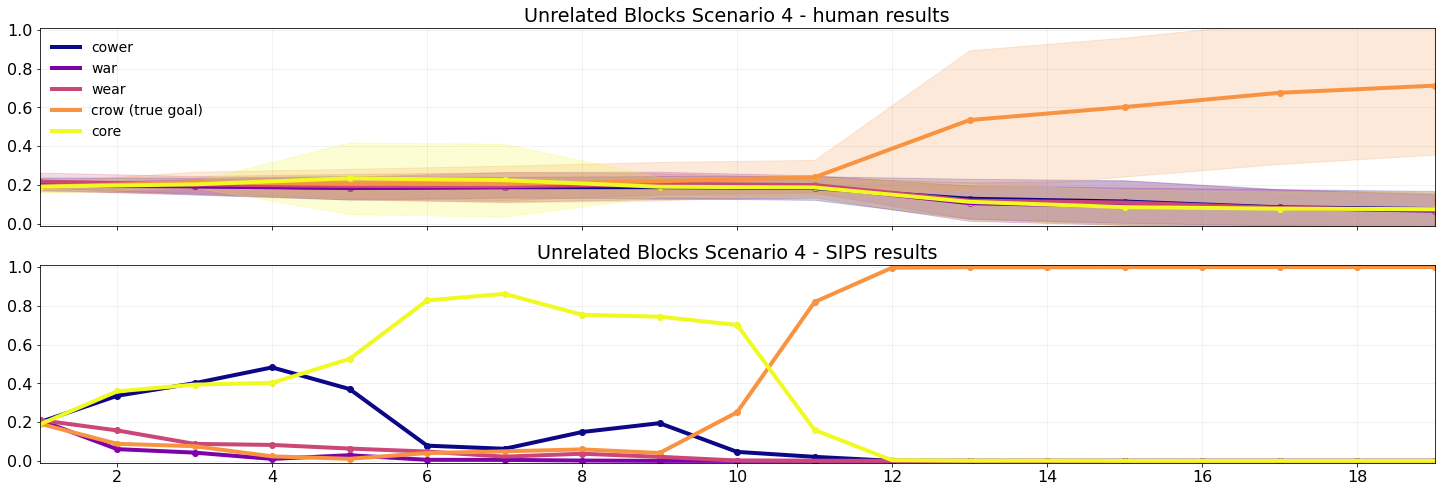

In [15]:
# plot_exp = ['1_1','1_2', '1_3', '1_4']
plot_exp = ['2_1','2_2', '2_3', '2_4','3_1','3_2', '3_3', '3_4']
# plot_exp = ['4_1','4_2', '4_3', '4_4']
# plot_exp = ['0_1','0_2', '0_3', '0_4']
for exp in plot_exp:
    plot_probs(exp)

In [16]:
# build averaged dictionary
avg_dict = dict()
averaged_columns = ['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4','true_goal_probs','time_spent']

for exp in predictions_dict_cleaned:
    avg_dict[exp] = []
    for time in predictions_dict_cleaned[exp]:
        timestep_average = dict()
        for result in predictions_dict[exp][time]:
            for column in averaged_columns:
                timestep_average[column] = timestep_average.get(column, 0)
                timestep_average[column] += result[column]
            timestep_average["timestep"] = time
        for column in averaged_columns:
            timestep_average[column] =  round(timestep_average[column]/len(predictions_dict_cleaned[exp][time]), 4)
        avg_dict[exp].append(timestep_average)

# Accuracy Tables

In [17]:
def posterior_accuracy(exp): 
    sips_accuracy = []
    human_accuracy = []
    #Get human data 
    human_data = pd.DataFrame.from_dict(avg_dict[exp], orient='columns', dtype=None, columns=None) 
    human_true_goal = human_data['true_goal_probs'].values
    #Load SIPS results 
    c,p = exp.split("_")
    filename = "experiment-" + str(c) + "-" + str(p) + ".csv"
    sips_data= generate_sips_mean_array(filename)
    sips_data = sips_data[list(range(0,len(sips_data)+1,2))]
    true_goal_index = goal_space_dict[exp].index(true_goal_dict[exp])
    sips_true_goal = sips_data[:, true_goal_index]
    if len(sips_true_goal) != len(human_true_goal): 
        print("length do not match, epx: ", epx)
        return None
    n = len(sips_true_goal)
    for i in [1,2,3,4]: 
        sips_accuracy.append(np.mean(sips_true_goal[:int((i*n)/4)]))
        human_accuracy.append(np.mean(human_true_goal[:int((i*n)/4)]))
    return sips_accuracy, human_accuracy

In [18]:
def top1_accuracy(exp): 
    sips_accuracy = []
    human_accuracy = []
    #Get human data 
    human_data = pd.DataFrame.from_dict(avg_dict[exp], orient='columns', dtype=None, columns=None)
    human_data = human_data[['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4']].values 
    #Load SIPS results 
    c,p = exp.split("_")
    filename = "experiment-" + str(c) + "-" + str(p) + ".csv"
    sips_data= generate_sips_mean_array(filename)
    sips_data = sips_data[list(range(0,len(sips_data)+1,2))]
    true_goal_index = goal_space_dict[exp].index(true_goal_dict[exp])
    if len(sips_data) != len(human_data): 
        print("length do not match, epx: ", epx)
        return None
    n = len(sips_data)
    for i in [1,2,3,4]: 
        ind = int((i*n)/4) -1
        temp_max = max(sips_data[ind, :])
        sips_accuracy.append(int([i for i, j in enumerate(sips_data[ind, :]) if j == temp_max] == [true_goal_index]))
        temp_max = max(human_data[ind, :])
        human_accuracy.append(int([i for i, j in enumerate(human_data[ind, :]) if j == temp_max] == [true_goal_index]))
    return sips_accuracy, human_accuracy


In [19]:
def total_variation(exp): 
    total_var = []
    #Get human data 
    human_data = pd.DataFrame.from_dict(avg_dict[exp], orient='columns', dtype=None, columns=None)
    human_data = human_data[['goal_probs_0', 'goal_probs_1','goal_probs_2','goal_probs_3','goal_probs_4']].values 
    #Load SIPS results 
    c,p = exp.split("_")
    filename = "experiment-" + str(c) + "-" + str(p) + ".csv"
    sips_data= generate_sips_mean_array(filename)
    sips_data = sips_data[list(range(0,len(sips_data)+1,2))]
    if len(sips_data) != len(human_data): 
        print("length do not match, epx: ", epx)
        return None
    n = len(sips_data)
    for i in [1,2,3,4]: 
        ind = int((i*n)/4) -1
        total_var.append(np.sum(np.abs(sips_data[ind, :] - human_data[ind, :]))/5)
        
    return total_var


In [20]:
# experiments = ['0_1','0_2', '0_3', '0_4',
#                 '1_1','1_2', '1_3', '1_4', 
#                '2_1','2_2', '2_3', '2_4', 
#                '3_1','3_2', '3_3', '3_4', 
#                '4_1','4_2', '4_3', '4_4']
experiments = ["2_1"]
posterior_results = dict()
top1_results = dict()
total_var = dict()
for exp in experiments:
    posterior_results[exp] = {'sips': [], 'human':[]}
    posterior_results[exp]['sips'], posterior_results[exp]['human'] = posterior_accuracy(exp)
    top1_results[exp] = {'sips': [], 'human':[]}
    top1_results[exp]['sips'], top1_results[exp]['human'] = top1_accuracy(exp)
    total_var[exp] = total_variation(exp)
    
# pd.DataFrame.from_dict(posterior_results[exp], orient='index', dtype=None, columns=None) 

In [21]:
exp = "2_1"
posterior_results[exp]

{'sips': [0.2609036358615179,
  0.5552976010459504,
  0.6692866063275565,
  0.7371341993014984],
 'human': [0.24039999999999997,
  0.29750000000000004,
  0.35473333333333334,
  0.4204846153846154]}

In [22]:
top1_results[exp]

{'sips': [0, 1, 1, 1], 'human': [0, 1, 1, 1]}

In [23]:
(0.18+0.1+0.06+0.06)/4

0.1